In [21]:
# importing packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Import data

In [2]:
# importing files

labels=pd.read_csv('train_labels.csv')
values=pd.read_csv('train_values.csv')

In [3]:
labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [4]:
values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [5]:
values.shape    #there are 13 variables and 180 entries

(180, 14)

In [6]:
np.sum(labels['patient_id']==values['patient_id'])   # checking that patient_id are the same in the two files

180

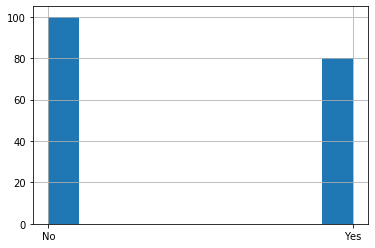

In [7]:
plt.hist(labels['heart_disease_present'])
plt.xticks([0,1],['No','Yes'])
plt.grid()
plt.show()

# Data pre-processing

In [8]:
labels.set_index('patient_id',inplace=True)
values.set_index('patient_id',inplace=True)

In [9]:
df_train=values.join(labels,on=values.index)

df_train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


In [10]:
df_train[['fixed_defect','normal','reversible_defect']]=pd.get_dummies(df_train['thal'])

df_train.drop('thal',axis=1,inplace=True)

In [11]:
df_train.shape

(180, 16)

In [12]:
df_train.info()   #all the variables are integer of float number. The patient ID is not a variable

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 16 columns):
slope_of_peak_exercise_st_segment       180 non-null int64
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
heart_disease_present                   180 non-null int64
fixed_defect                            180 non-null uint8
normal                                  180 non-null uint8
rever

In [13]:
# definition of the array characterizing the training set

X=np.array(df_train.drop('heart_disease_present',axis=1))
y=df_train['heart_disease_present']   # I save in y my training results

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler=StandardScaler()
X_std=scaler.fit_transform(X)
#X_std=X

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25,random_state=32)

y_train_dumm=pd.get_dummies(y_train)
y_test_dumm=pd.get_dummies(y_test)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

# Neural Network

In [14]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

# Here I build the neural network
ncols=X_train.shape[1]

model=Sequential()

# 1th hidden layer
model.add(Dense(100,input_shape=(ncols,),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(2,activation='sigmoid'))

# optimizer
#opt=SGD(lr=0.02,momentum=0.5, nesterov=False)

# compile
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# monitor
early_stopping_monitor = EarlyStopping(patience=50,monitor='val_acc')
checkpoint=ModelCheckpoint(filepath='best_model.hdf5',save_weights_only=False,monitor='val_acc',mode='auto',save_best_only=True,verbose=1)


# fit the model
history=model.fit(X_train, y_train_dumm ,epochs=500,validation_data=(X_test,y_test_dumm),callbacks=[early_stopping_monitor,checkpoint],class_weight=class_weights)
print("Loss function: " + model.loss)

Train on 135 samples, validate on 45 samples
Epoch 1/500
135/135 [==============================] - 2s 14ms/step - loss: 0.7029 - acc: 0.4926 - val_loss: 0.6436 - val_acc: 0.6778

Epoch 00001: val_acc improved from -inf to 0.67778, saving model to best_model.hdf5
Epoch 2/500
135/135 [==============================] - 0s 273us/step - loss: 0.6458 - acc: 0.6704 - val_loss: 0.5869 - val_acc: 0.7889

Epoch 00002: val_acc improved from 0.67778 to 0.78889, saving model to best_model.hdf5
Epoch 3/500
135/135 [==============================] - 0s 294us/step - loss: 0.5800 - acc: 0.7704 - val_loss: 0.5394 - val_acc: 0.8111

Epoch 00003: val_acc improved from 0.78889 to 0.81111, saving model to best_model.hdf5
Epoch 4/500
135/135 [==============================] - 0s 206us/step - loss: 0.5441 - acc: 0.7704 - val_loss: 0.4982 - val_acc: 0.8222

Epoch 00004: val_acc improved from 0.81111 to 0.82222, saving model to best_model.hdf5
Epoch 5/500
135/135 [==============================] - 0s 572us/ste

135/135 [==============================] - 0s 260us/step - loss: 0.2306 - acc: 0.9037 - val_loss: 0.3372 - val_acc: 0.8778

Epoch 00043: val_acc did not improve from 0.87778
Epoch 44/500
135/135 [==============================] - 0s 275us/step - loss: 0.2100 - acc: 0.9185 - val_loss: 0.3392 - val_acc: 0.8778

Epoch 00044: val_acc did not improve from 0.87778
Epoch 45/500
135/135 [==============================] - 0s 275us/step - loss: 0.2182 - acc: 0.9259 - val_loss: 0.3346 - val_acc: 0.8889

Epoch 00045: val_acc improved from 0.87778 to 0.88889, saving model to best_model.hdf5
Epoch 46/500
135/135 [==============================] - 0s 268us/step - loss: 0.2042 - acc: 0.9333 - val_loss: 0.3381 - val_acc: 0.8889

Epoch 00046: val_acc did not improve from 0.88889
Epoch 47/500
135/135 [==============================] - 0s 257us/step - loss: 0.2005 - acc: 0.9370 - val_loss: 0.3474 - val_acc: 0.8778

Epoch 00047: val_acc did not improve from 0.88889
Epoch 48/500
135/135 [===================


Epoch 00086: val_acc did not improve from 0.88889
Epoch 87/500
135/135 [==============================] - 0s 432us/step - loss: 0.0883 - acc: 0.9741 - val_loss: 0.4586 - val_acc: 0.8778

Epoch 00087: val_acc did not improve from 0.88889
Epoch 88/500
135/135 [==============================] - 0s 287us/step - loss: 0.0812 - acc: 0.9704 - val_loss: 0.4588 - val_acc: 0.8778

Epoch 00088: val_acc did not improve from 0.88889
Epoch 89/500
135/135 [==============================] - 0s 265us/step - loss: 0.0862 - acc: 0.9630 - val_loss: 0.4743 - val_acc: 0.8556

Epoch 00089: val_acc did not improve from 0.88889
Epoch 90/500
135/135 [==============================] - 0s 301us/step - loss: 0.0824 - acc: 0.9741 - val_loss: 0.4921 - val_acc: 0.8444

Epoch 00090: val_acc did not improve from 0.88889
Epoch 91/500
135/135 [==============================] - 0s 272us/step - loss: 0.0866 - acc: 0.9593 - val_loss: 0.5020 - val_acc: 0.8444

Epoch 00091: val_acc did not improve from 0.88889
Epoch 92/500
1

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Evaluate the performance

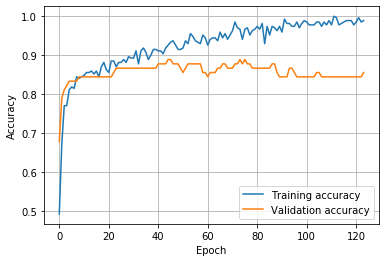

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training accuracy','Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 11,902
Trainable params: 11,902
Non-trainable params: 0
_________________________________________________________________


In [18]:
my_model = load_model('best_model.hdf5')

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred=np.argmax(my_model.predict(X_test),axis=1)

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

[[27  4]
 [ 1 13]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        31
           1       0.76      0.93      0.84        14

    accuracy                           0.89        45
   macro avg       0.86      0.90      0.88        45
weighted avg       0.90      0.89      0.89        45



In [20]:
print('Maximum validation accuracy',round(np.max(history.history['val_acc']),2))

Maximum validation accuracy 0.89
